In [32]:
'''correlations in P-E regimes'''

'correlations in P-E regimes'

In [1]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cyclone_obs import *
from cyclone_metrics import *
from my_binned import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [2]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6
fig_dir = '/glade/derecho/scratch/geethma/figures_GFB/'

In [3]:
# --- TOA means
from TOAf import *
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)
common_members = filtered_TOA_15.runs
common_members = common_members[common_members != 175]

In [4]:
# gpe
file = np.load('/glade/derecho/scratch/cisong/backup_FOR_wyom0124/variables_filtered/pe.npz')
PE_g_mean = xr.DataArray(file['data'], dims=['runs'], coords={'runs':file['runs']})  # Global dP/dLWP [s-1]
PE_g_mean = PE_g_mean.sel(runs=common_members)

In [5]:
var_list = ['dTSmap_gol', 'dLWPmap_gol', 'pe_maps_ol', 'dPE_maps_gol']  # , 'dSWCREmap', 'dLWCREmap', 'wvp_maps_ol', 'w500_maps_ol', 
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

dGMT = lat_weight_mean(var_dict['dTSmap_gol'])[0]  # ∆GMT [K]
pe_maps_ol = var_dict['pe_maps_ol']*86400  # PD P-E [kgm-2day-1]
dLWP_g = var_dict['dLWPmap_gol']/dGMT  # ∆LWP/∆GMT [kgm-2K-1] 
dPE = var_dict['dPE_maps_gol']/dGMT  # ∆P-E/∆GMT [kgm-2day-1K-1]

dTSmap_gol
dLWPmap_gol
pe_maps_ol
dPE_maps_gol


In [6]:
# all pressure all cloud feedbacks
ds_kernel = {}
for mem_run in common_members:
    pk = 'all_pressure'
    tk = 'all'

    mem = str(mem_run).zfill(3)
    path = (
        f"/glade/derecho/scratch/travisa/CAM6_kernels/"
        f"member_number_{mem}/"
        f"CAM6_PPE_CRK_decomp_{pk}_{tk}_cloud.nc"
    )

    if not os.path.exists(path):
        print(f"Skipping member {mem}: file not found")
        continue

    ds_kernel[mem + pk + tk] = xr.open_dataset(path)

# now for kernel feedback take the global, subtropical, and midltitude means
def trav_fbvar(fbvar, region_dic, ds_kernel=ds_kernel, dGMT=dGMT, common_members=common_members):
    '''return each cloud feedback variable separated into regions.
       fbvar is the feedback component name in strings.'''

    regions = list(region_dic.keys())
    
    SWkernel_regmean = {}
    for reg in (regions):
        SWkernel_list = []
        for mem_run in (common_members):
            mem = str(mem_run).zfill(3)
            SWkernel = ds_kernel[mem+'all_pressure'+'all'][fbvar].mean('time')
            SWkernel_list.append(SWkernel)
    
        SWkernel_all = xr.concat(SWkernel_list,'runs').assign_coords({'runs':common_members})
        SWkernel_regmean[reg] = SWkernel_all.load()/dGMT
    return SWkernel_regmean

# cloud feedback components
region_dic = {
    'global' : [0, 90]
}
LWcld_tot_fb_global = trav_fbvar('LWcld_tot', region_dic)
SWcld_tot_fb_global = trav_fbvar('SWcld_tot', region_dic)
totdCRE_g = LWcld_tot_fb_global['global'] + SWcld_tot_fb_global['global']
totdCRE_g = totdCRE_g.sel(runs=common_members)

LWcld_tau_amt = trav_fbvar('LWcld_tau', region_dic)['global'] + trav_fbvar('LWcld_amt', region_dic)['global']
SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global'] + trav_fbvar('SWcld_amt', region_dic)['global']
totcld_tau_amt = LWcld_tau_amt + SWcld_tau_amt
totcld_tau_amt = totcld_tau_amt.sel(runs=common_members)

In [7]:
# gpe selected
PE_g_mean = PE_g_mean.sel(runs=common_members) 
grad = [PE_g_mean.data]
grad = np.array(grad)

/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Figure size 449x280 with 0 Axes>

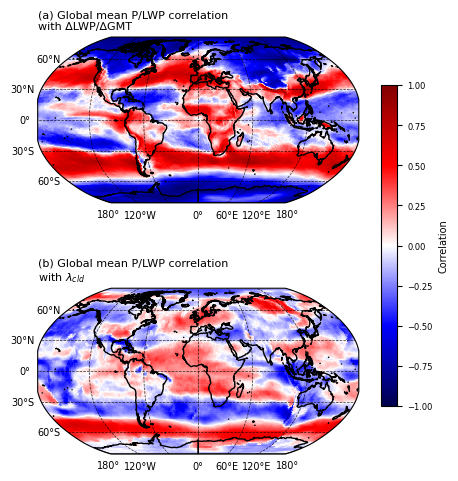

In [8]:
# ----- Plot correlation of global precipitation eff with ∆LWP and lambda scaled by PD P-E in maps 
totdCRE_g_t = np.transpose(totdCRE_g.data, (0, 2, 1))
dVAR_map_o = [dLWP_g.data, totdCRE_g_t]
dVAR_map_o = np.array(dVAR_map_o)
dVar_name = ['∆LWP/∆GMT', '$λ_{cld}$']

grad = [PE_g_mean.data]
grad = np.array(grad)
grad_name = ['P/LWP']

correlation_dic = {}  # dictionary to put correlations 

# Set figure width to 11.4 cm = 4.49 inches for PNAS single-column
fig = plt.figure(figsize=(4.49, 2.8))  # Adjusted height to maintain horizontal layout

lat_sh = dLWP_g.lat.shape[0]
lon_sh = dLWP_g.lon.shape[0]

nums = [[0, 0], [0, 1]]
title_num = ['(a) ', '(b) ']

fig, axs = plt.subplots(2, 1, figsize=(4.49, 5), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

for ax_n, ax in enumerate(axs.flat):
    dvar = dVar_name[ax_n]
    print()
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    correlation = np.full((lat_sh, lon_sh), np.nan)
    for i in range(lat_sh):
        for j in range(lon_sh):
            correlation[i, j] = stats.spearmanr(grad[g], dVAR_map_o[d, :, i, j], nan_policy='omit')[0]

    cbar_img = ax.pcolormesh(dLWP_g.lon, dLWP_g.lat, correlation,
                             transform=ccrs.PlateCarree(), cmap='seismic',
                             vmin=-1, vmax=1)

    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.GSHHSFeature(scale='auto', edgecolor='black'))
    ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
    ax.set_title(title_num[ax_n] + 'Global mean ' + grad_name[g] + ' correlation\nwith ' + dVar_name[d],
                 fontsize=title_fontsize, loc='left')
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': label_fontsize}  # optional: set label font size
    gl.ylabel_style = {'fontsize': label_fontsize}
    correlation_dic[dvar] = correlation

cbar = fig.colorbar(cbar_img, ax=axs, orientation='vertical', fraction=0.05, pad=0.07)
cbar.set_label('Correlation', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

In [9]:
# --- cyclone observations
from cyclone_obs import *
obs_dict = cyclone_obs()

cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']/3600.  #[mm/s]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(prc_bin)/np.gradient(lwp_bin)*count)/np.nansum(count)

obs_grad_LWP_PRC = obs_grad

ecpe_uncertainty = np.sqrt(0.10**2 + 0.35**2 + 0.27**2)  # updated to include the sampling uncertainty
lower_bound_PRC = obs_grad_LWP_PRC - ecpe_uncertainty * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + ecpe_uncertainty * obs_grad_LWP_PRC

obs_pe_metric = obs_grad_LWP_PRC  # observational EC precipitation efficiency
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  # upper and lower bounds with uncertainty
print(f'obs_grad_LWP_PRC = {obs_grad} +/- {ecpe_uncertainty * obs_grad_LWP_PRC}')

obs_grad_LWP_PRC = 0.0015741210734605301 +/- 0.0007134086202266089


In [10]:
# --- ecpe metric
_, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = 1./(PPE_grad_LWP_PRC.sel(runs=common_members)*86400.)  # [s-1]
# PPE_grad_LWP_WCB = 1/(PPE_grad_LWP_WCB.sel(runs=common_members))

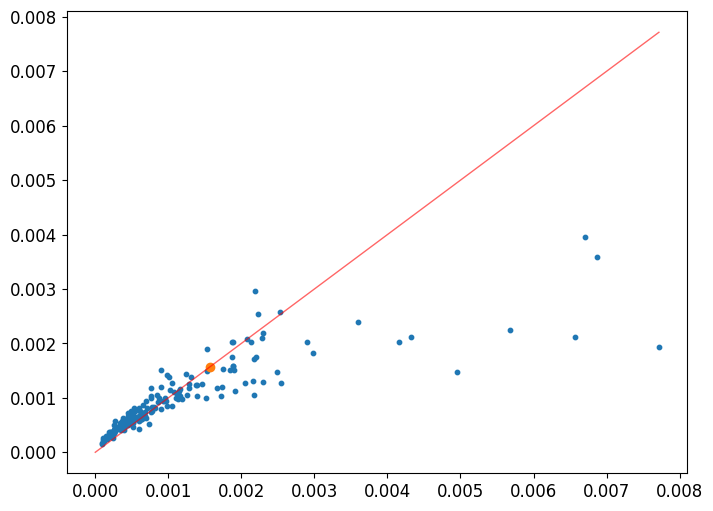

In [11]:
# --- gpe metric vs ecpe metric
plt.scatter((PPE_grad_LWP_PRC.data), PE_g_mean.data, s=10)
x_values = np.sort((PPE_grad_LWP_PRC.data))
lim = x_values[-1]
plt.plot([0,lim], [0, lim], 'r', alpha=0.6, linewidth=1)
plt.scatter(obs_pe_metric, obs_pe_metric)

In [12]:
# --- Save the constrained feedbacks
constrained_fb = []
prior_fb = []

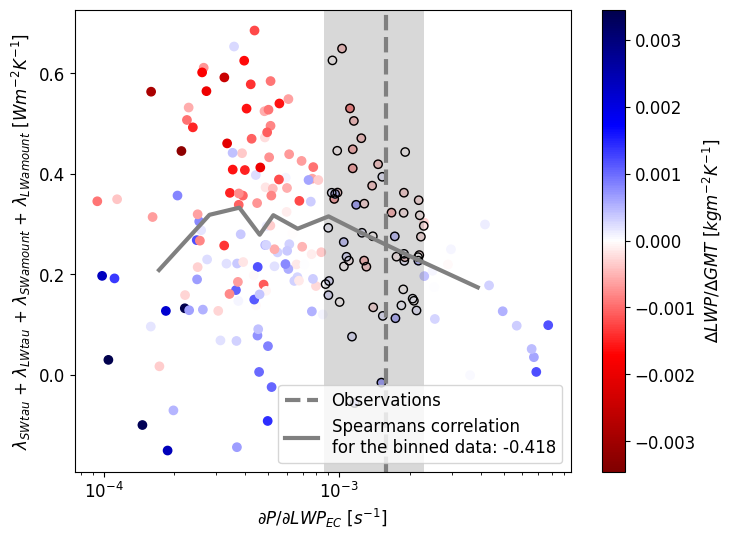

In [13]:
# --- choose only the areas with positive PD P-E in each run

mask_pos = (pe_maps_ol.data > 0) & np.isfinite(pe_maps_ol.data)
# masked total cloud feedback
totdCRE_masked = np.where(
    mask_pos,
    totdCRE_g_t,
    np.nan
)
totdCRE_g_xr = xr.DataArray(
    totdCRE_masked,
    dims=('runs', 'lat', 'lon'),
    coords={
        'runs': dLWP_g.runs,
        'lat': dLWP_g.lat,
        'lon': dLWP_g.lon,
    },
    name='totdCRE_masked'
)
# masked tau and amount cloud feedback
totcld_tau_amt_g_t = np.transpose(totcld_tau_amt.data, (0, 2, 1))
totcld_tau_amt_masked = np.where(
    mask_pos,
    totcld_tau_amt_g_t,
    np.nan
)
totcld_tau_amt_g_xr = xr.DataArray(
    totcld_tau_amt_masked,
    dims=('runs', 'lat', 'lon'),
    coords={
        'runs': dLWP_g.runs,
        'lat': dLWP_g.lat,
        'lon': dLWP_g.lon,
    },
    name='totcld_tau_amt_masked'
)
# masked ∆LWP
dLWP_g_masked = np.where(
    mask_pos,
    dLWP_g,
    np.nan
)
dLWP_g_xr = xr.DataArray(
    dLWP_g_masked,
    dims=('runs', 'lat', 'lon'),
    coords={
        'runs': dLWP_g.runs,
        'lat': dLWP_g.lat,
        'lon': dLWP_g.lon,
    },
    name='dLWP_masked'
)

# --- mean in the masked lamcld and ∆LWP
dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

# --- plot in positive correlation
X_scatter = PPE_grad_LWP_PRC.data
Y_scatter = cf_mean.data
clabel = '$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$'
scatter = plt.scatter(X_scatter, Y_scatter, 
                      c=dLWP_TSmap_sel_mean, 
                      cmap='seismic_r')
plt.axvline(x=obs_pe_metric, color='grey', linestyle='--', label='Observations')
plt.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
# plot binned data
y_bin, x_bin, bin_edges, count = my_binned(X_scatter, Y_scatter, num_bins=10, percentiles=True)
c_ind = count>10
corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])
label = f'Spearmans correlation\nfor the binned data: {corr:.3f}'
plt.plot(x_bin[c_ind], y_bin[c_ind], 'grey', label=label)
# Set the axis labels
plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$')
plt.ylabel(clabel)

plt.legend()
# colorbar
cb = plt.colorbar(scatter)
cb.set_label('$∆LWP/∆GMT$ $[kgm^{-2}K^{-1}]$')
max_abs_value = abs(dLWP_TSmap_sel_mean).max().item()
scatter.set_clim(-max_abs_value, max_abs_value)

# Select runs where PPE_grad_LWP_PRC is between lower and upper bounds
mask = (PPE_grad_LWP_PRC >= lower_pe_metric) & (PPE_grad_LWP_PRC <= upper_pe_metric)
# Select the runs (members) that satisfy the mask
PPE_constrained = PPE_grad_LWP_PRC.where(mask, drop=True)
# totdCRE_g_xr_mean = lat_weight_mean(totdCRE_g_xr)[0]
constrained_positive = cf_mean.where(cf_mean['runs'].isin(PPE_constrained['runs']), drop=True)
plt.scatter(PPE_constrained, constrained_positive, facecolors='none', edgecolors='black', marker='o')
# plt.scatter(PPE_constrained, constrained_positive, color='black')
plt.xscale('log')
constrained_fb.append(constrained_positive.data)
prior_fb.append(cf_mean.data)

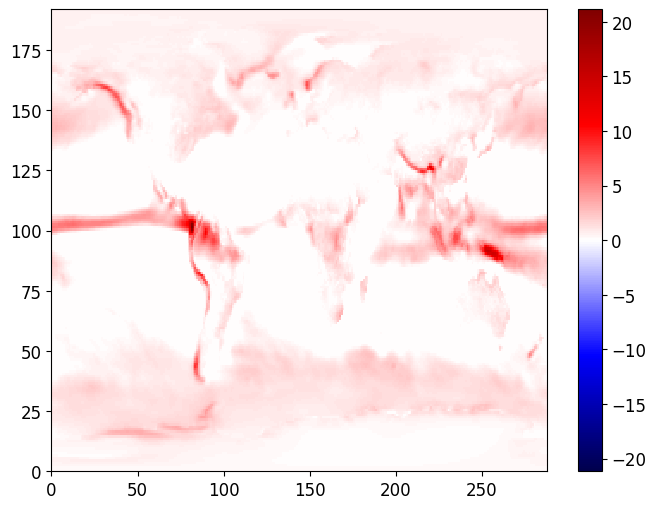

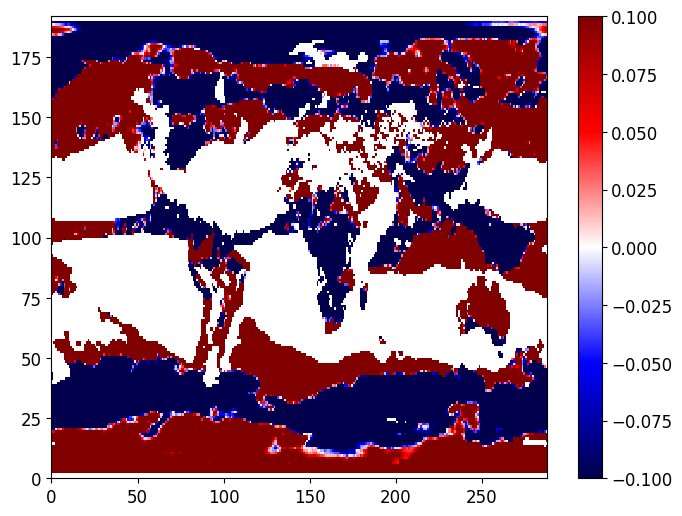

In [14]:
scatter = plt.pcolormesh(pe_maps_ol[0]*mask_pos[0], cmap='seismic')
plt.colorbar()
max_abs_value = abs(pe_maps_ol[0]).max().item()
scatter.set_clim(-max_abs_value, max_abs_value)

plt.figure()
scatter = plt.pcolormesh(totcld_tau_amt_masked[0], cmap='seismic')
plt.colorbar()
max_abs_value = abs(totcld_tau_amt_masked[0]).max().item()
scatter.set_clim(-max_abs_value, max_abs_value)

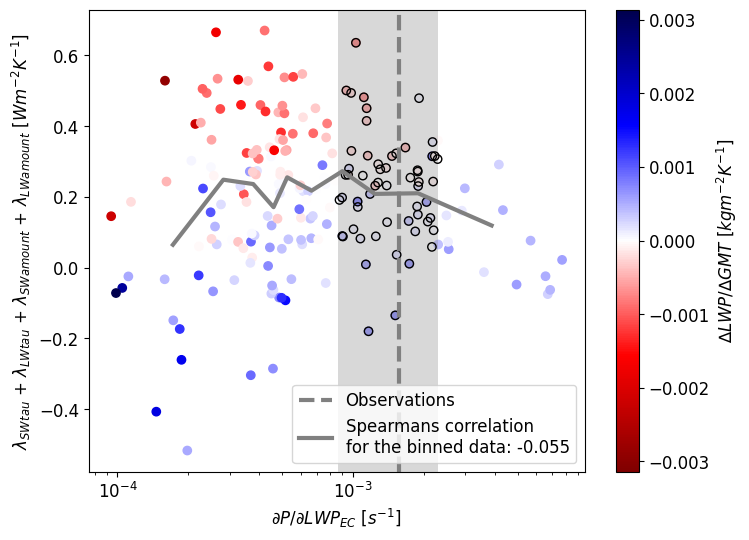

In [15]:
# --- choose only the areas with negative PD P-E in each run

mask_pos = (pe_maps_ol.data < 0) & np.isfinite(pe_maps_ol.data)
# masked total cloud feedback
totdCRE_masked = np.where(
    mask_pos,
    totdCRE_g_t,
    np.nan
)
totdCRE_g_xr = xr.DataArray(
    totdCRE_masked,
    dims=('runs', 'lat', 'lon'),
    coords={
        'runs': dLWP_g.runs,
        'lat': dLWP_g.lat,
        'lon': dLWP_g.lon,
    },
    name='totdCRE_masked'
)
# masked tau and amount cloud feedback
totcld_tau_amt_g_t = np.transpose(totcld_tau_amt.data, (0, 2, 1))
totcld_tau_amt_masked = np.where(
    mask_pos,
    totcld_tau_amt_g_t,
    np.nan
)
totcld_tau_amt_g_xr = xr.DataArray(
    totcld_tau_amt_masked,
    dims=('runs', 'lat', 'lon'),
    coords={
        'runs': dLWP_g.runs,
        'lat': dLWP_g.lat,
        'lon': dLWP_g.lon,
    },
    name='totcld_tau_amt_masked'
)
# masked ∆LWP
dLWP_g_masked = np.where(
    mask_pos,
    dLWP_g,
    np.nan
)
dLWP_g_xr = xr.DataArray(
    dLWP_g_masked,
    dims=('runs', 'lat', 'lon'),
    coords={
        'runs': dLWP_g.runs,
        'lat': dLWP_g.lat,
        'lon': dLWP_g.lon,
    },
    name='dLWP_masked'
)

# --- mean in the masked lamcld and ∆LWP
dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

# --- plot in positive correlation
X_scatter = PPE_grad_LWP_PRC.data
Y_scatter = cf_mean.data
clabel = '$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$'
scatter = plt.scatter(X_scatter, Y_scatter, 
                      c=dLWP_TSmap_sel_mean, 
                      cmap='seismic_r')
plt.axvline(x=obs_pe_metric, color='grey', linestyle='--', label='Observations')
plt.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
# plot binned data
y_bin, x_bin, bin_edges, count = my_binned(X_scatter, Y_scatter, num_bins=10, percentiles=True)
c_ind = count>10
corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])
label = f'Spearmans correlation\nfor the binned data: {corr:.3f}'
plt.plot(x_bin[c_ind], y_bin[c_ind], 'grey', label=label)
# Set the axis labels
plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$')
plt.ylabel(clabel)

plt.legend()
# colorbar
cb = plt.colorbar(scatter)
cb.set_label('$∆LWP/∆GMT$ $[kgm^{-2}K^{-1}]$')
max_abs_value = abs(dLWP_TSmap_sel_mean).max().item()
scatter.set_clim(-max_abs_value, max_abs_value)

# Select runs where PPE_grad_LWP_PRC is between lower and upper bounds
mask = (PPE_grad_LWP_PRC >= lower_pe_metric) & (PPE_grad_LWP_PRC <= upper_pe_metric)
# Select the runs (members) that satisfy the mask
PPE_constrained = PPE_grad_LWP_PRC.where(mask, drop=True)
# totdCRE_g_xr_mean = lat_weight_mean(totdCRE_g_xr)[0]
constrained_positive = cf_mean.where(cf_mean['runs'].isin(PPE_constrained['runs']), drop=True)
plt.scatter(PPE_constrained, constrained_positive, facecolors='none', edgecolors='black', marker='o')
# plt.scatter(PPE_constrained, constrained_positive, color='black')
plt.xscale('log')
constrained_fb.append(constrained_positive.data)
prior_fb.append(cf_mean.data)

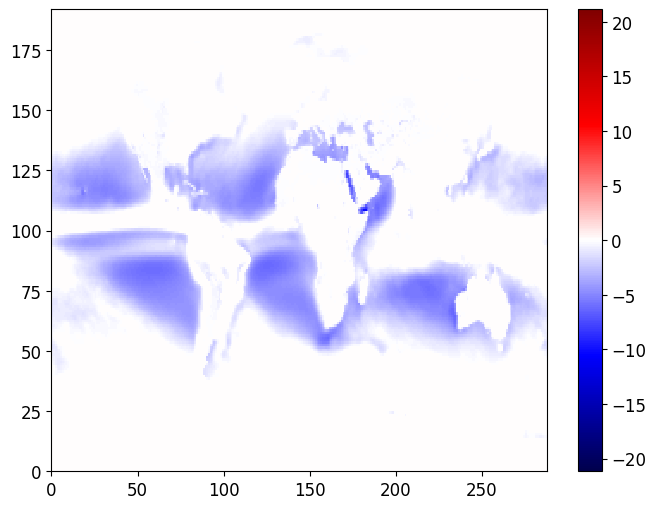

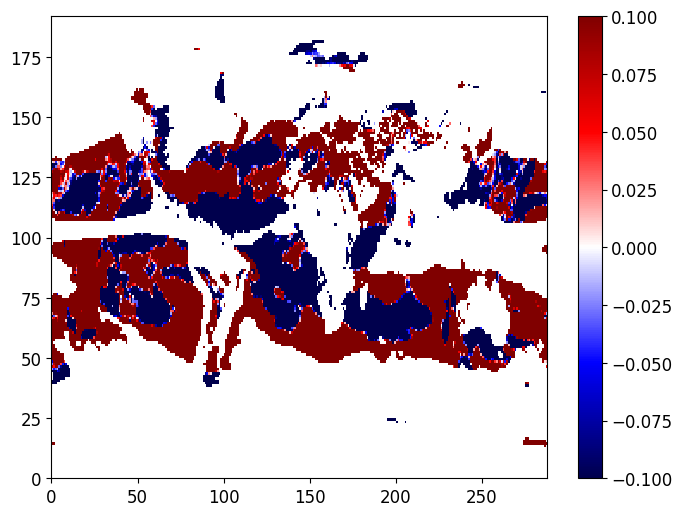

In [31]:
scatter = plt.pcolormesh(pe_maps_ol[0]*mask_pos[0], cmap='seismic')
plt.colorbar()
max_abs_value = abs(pe_maps_ol[0]).max().item()
scatter.set_clim(-max_abs_value, max_abs_value)

plt.figure()
scatter = plt.pcolormesh(totcld_tau_amt_masked[0], cmap='seismic')
plt.colorbar()
max_abs_value = abs(totcld_tau_amt_masked[0]).max()
scatter.set_clim(-max_abs_value, max_abs_value)

In [17]:
# # --- choose only the areas with negative ∆P-E in each run

# mask_pos = (dPE.data < 0) & np.isfinite(dPE.data)
# # masked total cloud feedback
# totdCRE_masked = np.where(
#     mask_pos,
#     totdCRE_g_t,
#     np.nan
# )
# totdCRE_g_xr = xr.DataArray(
#     totdCRE_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='totdCRE_masked'
# )
# # masked tau and amount cloud feedback
# totcld_tau_amt_g_t = np.transpose(totcld_tau_amt.data, (0, 2, 1))
# totcld_tau_amt_masked = np.where(
#     mask_pos,
#     totcld_tau_amt_g_t,
#     np.nan
# )
# totcld_tau_amt_g_xr = xr.DataArray(
#     totcld_tau_amt_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='totcld_tau_amt_masked'
# )
# # masked ∆LWP
# dLWP_g_masked = np.where(
#     mask_pos,
#     dLWP_g,
#     np.nan
# )
# dLWP_g_xr = xr.DataArray(
#     dLWP_g_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='dLWP_masked'
# )

# # --- mean in the masked lamcld and ∆LWP
# dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
# cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

# # --- plot in positive correlation
# X_scatter = PPE_grad_LWP_PRC.data
# Y_scatter = cf_mean.data
# clabel = '$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$'
# scatter = plt.scatter(X_scatter, Y_scatter, 
#                       c=dLWP_TSmap_sel_mean, 
#                       cmap='seismic_r')
# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--', label='Observations')
# plt.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
# # plot binned data
# y_bin, x_bin, bin_edges, count = my_binned(X_scatter, Y_scatter, num_bins=10, percentiles=True)
# c_ind = count>10
# corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])
# label = f'Spearmans correlation\nfor the binned data: {corr:.3f}'
# plt.plot(x_bin[c_ind], y_bin[c_ind], 'grey', label=label)
# # Set the axis labels
# plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$')
# plt.ylabel(clabel)

# plt.legend()
# # colorbar
# cb = plt.colorbar(scatter)
# cb.set_label('$∆LWP/∆GMT$ $[kgm^{-2}K^{-1}]$')
# max_abs_value = abs(dLWP_TSmap_sel_mean).max().item()
# scatter.set_clim(-max_abs_value, max_abs_value)

# # Select runs where PPE_grad_LWP_PRC is between lower and upper bounds
# mask = (PPE_grad_LWP_PRC >= lower_pe_metric) & (PPE_grad_LWP_PRC <= upper_pe_metric)
# # Select the runs (members) that satisfy the mask
# PPE_constrained = PPE_grad_LWP_PRC.where(mask, drop=True)
# # totdCRE_g_xr_mean = lat_weight_mean(totdCRE_g_xr)[0]
# constrained_positive = cf_mean.where(cf_mean['runs'].isin(PPE_constrained['runs']), drop=True)
# plt.scatter(PPE_constrained, constrained_positive, facecolors='none', edgecolors='black', marker='o')
# # plt.scatter(PPE_constrained, constrained_positive, color='black')
# plt.xscale('log')
# constrained_fb.append(constrained_positive.data)
# prior_fb.append(cf_mean.data)

In [18]:
# type(dPE.data)
# print(np.shape(dPE.data))

In [19]:
# type(correlation_dic['$λ_{cld}$'])
# print(np.shape(correlation_dic['$λ_{cld}$']))

In [20]:
# # --- choose the areas with positive correlation in lamcld and gpe
# mask_pos = (correlation_dic['$λ_{cld}$'] > 0) & np.isfinite(correlation_dic['$λ_{cld}$'])
# # masked total cloud feedback
# totdCRE_masked = np.where(
#     mask_pos[None, :, :],
#     totdCRE_g_t,
#     np.nan
# )
# totdCRE_g_xr = xr.DataArray(
#     totdCRE_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='totdCRE_masked'
# )
# # masked tau and amount cloud feedback
# totcld_tau_amt_g_t = np.transpose(totcld_tau_amt.data, (0, 2, 1))
# totcld_tau_amt_masked = np.where(
#     mask_pos[None, :, :],
#     totcld_tau_amt_g_t,
#     np.nan
# )
# totcld_tau_amt_g_xr = xr.DataArray(
#     totcld_tau_amt_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='totcld_tau_amt_masked'
# )
# # masked ∆LWP
# dLWP_g_masked = np.where(
#     mask_pos[None, :, :],
#     dLWP_g,
#     np.nan
# )
# dLWP_g_xr = xr.DataArray(
#     dLWP_g_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='dLWP_masked'
# )

# # --- mean in the masked lamcld and ∆LWP
# dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
# cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

# # --- plot in positive correlation
# X_scatter = PPE_grad_LWP_PRC.data
# Y_scatter = cf_mean.data
# clabel = '$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$'
# scatter = plt.scatter(X_scatter, Y_scatter, 
#                       c=dLWP_TSmap_sel_mean, 
#                       cmap='seismic_r')
# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--', label='Observations')
# plt.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
# # plot binned data
# y_bin, x_bin, bin_edges, count = my_binned(X_scatter, Y_scatter, num_bins=10, percentiles=True)
# c_ind = count>10
# corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])
# label = f'Spearmans correlation\nfor the binned data: {corr:.3f}'
# plt.plot(x_bin[c_ind], y_bin[c_ind], 'grey', label=label)
# # Set the axis labels
# plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$')
# plt.ylabel(clabel)

# plt.legend()
# # colorbar
# cb = plt.colorbar(scatter)
# cb.set_label('$∆LWP/∆GMT$ $[kgm^{-2}K^{-1}]$')
# max_abs_value = abs(dLWP_TSmap_sel_mean).max().item()
# scatter.set_clim(-max_abs_value, max_abs_value)

# # Select runs where PPE_grad_LWP_PRC is between lower and upper bounds
# mask = (PPE_grad_LWP_PRC >= lower_pe_metric) & (PPE_grad_LWP_PRC <= upper_pe_metric)
# # Select the runs (members) that satisfy the mask
# PPE_constrained = PPE_grad_LWP_PRC.where(mask, drop=True)
# # totdCRE_g_xr_mean = lat_weight_mean(totdCRE_g_xr)[0]
# constrained_positive = cf_mean.where(cf_mean['runs'].isin(PPE_constrained['runs']), drop=True)
# plt.scatter(PPE_constrained, constrained_positive, facecolors='none', edgecolors='black', marker='o')
# # plt.scatter(PPE_constrained, constrained_positive, color='black')
# plt.xscale('log')
# constrained_fb.append(constrained_positive.data)
# prior_fb.append(cf_mean.data)

In [21]:
# # --- choose the areas with negative correlation in lamcld and gpe
# mask_pos = (correlation_dic['$λ_{cld}$'] < 0) & np.isfinite(correlation_dic['$λ_{cld}$'])
# # masked total cloud feedback
# totdCRE_masked = np.where(
#     mask_pos[None, :, :],
#     totdCRE_g_t,
#     np.nan
# )
# totdCRE_g_xr = xr.DataArray(
#     totdCRE_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='totdCRE_masked'
# )
# # masked tau and amount cloud feedback
# totcld_tau_amt_g_t = np.transpose(totcld_tau_amt.data, (0, 2, 1))
# totcld_tau_amt_masked = np.where(
#     mask_pos[None, :, :],
#     totcld_tau_amt_g_t,
#     np.nan
# )
# totcld_tau_amt_g_xr = xr.DataArray(
#     totcld_tau_amt_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='totcld_tau_amt_masked'
# )
# # masked ∆LWP
# dLWP_g_masked = np.where(
#     mask_pos[None, :, :],
#     dLWP_g,
#     np.nan
# )
# dLWP_g_xr = xr.DataArray(
#     dLWP_g_masked,
#     dims=('runs', 'lat', 'lon'),
#     coords={
#         'runs': dLWP_g.runs,
#         'lat': dLWP_g.lat,
#         'lon': dLWP_g.lon,
#     },
#     name='dLWP_masked'
# )

# # --- mean in the masked lamcld and ∆LWP
# dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
# cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

# # --- plot in positive correlation
# X_scatter = PPE_grad_LWP_PRC.data
# Y_scatter = cf_mean.data
# clabel = '$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$'
# scatter = plt.scatter(X_scatter, Y_scatter, 
#                       c=dLWP_TSmap_sel_mean, 
#                       cmap='seismic_r')
# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--', label='Observations')
# plt.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
# # plot binned data
# y_bin, x_bin, bin_edges, count = my_binned(X_scatter, Y_scatter, num_bins=10, percentiles=True)
# c_ind = count>10
# corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])
# label = f'Spearmans correlation\nfor the binned data: {corr:.3f}'
# plt.plot(x_bin[c_ind], y_bin[c_ind], 'grey', label=label)
# # Set the axis labels
# plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$')
# plt.ylabel(clabel)
# plt.xscale('log')
# plt.legend()
# # colorbar
# cb = plt.colorbar(scatter)
# cb.set_label('$∆LWP/∆GMT$ $[kgm^{-2}K^{-1}]$')
# max_abs_value = abs(dLWP_TSmap_sel_mean).max().item()
# scatter.set_clim(-max_abs_value, max_abs_value)
# # totdCRE_g_xr_mean = lat_weight_mean(totdCRE_g_xr)[0]
# constrained_negative = cf_mean.where(cf_mean['runs'].isin(PPE_constrained['runs']), drop=True)
# plt.scatter(PPE_constrained, constrained_negative, facecolors='none', edgecolors='black', marker='o')
# constrained_fb.append(constrained_negative.data)
# prior_fb.append(cf_mean.data)

In [22]:
# plt.hist(prior_fb[0])
# plt.hist(constrained_fb[0])
# plt.title('cld tau+amt in moisture converging regions')

In [23]:
# plt.hist(prior_fb[1])
# plt.hist(constrained_fb[1])
# plt.title('cld tau+amt in moisture diverging regions')

In [24]:
# weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
weights = [1, 1]
weights = np.array(weights) / np.sum(weights)

In [25]:
# --- function to do the bootstrap
from numpy.random import choice
def bootstrap_mean_lat(LATDATA,weights_lats):
    n_boot=10000 ## number of bootstraps
    lat_resample=[None]*len(LATDATA)
    for i in range(len(LATDATA)):
        print(i)
        lat_resample[i]=choice(LATDATA[i],n_boot,replace=True) ## create MC samples

    global_mean=np.zeros(n_boot) ## zero out bootstrap sample of global mean
    for i in range(len(LATDATA)):
        global_mean=lat_resample[i]*weights_lats[i]+global_mean## add together the boot straps
    return global_mean

In [26]:
global_mean=bootstrap_mean_lat(constrained_fb,weights)

0
1


(array([  31.,  259.,  707., 1853., 3090., 2450., 1072.,  446.,   76.,
          16.]),
 array([-0.09769129, -0.02369864,  0.050294  ,  0.12428665,  0.19827929,
         0.27227194,  0.34626458,  0.42025723,  0.49424988,  0.56824252,
         0.64223517]),
 <BarContainer object of 10 artists>)

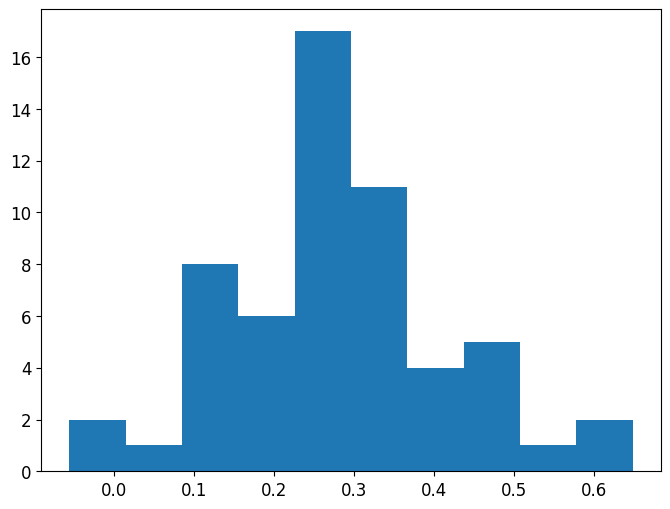

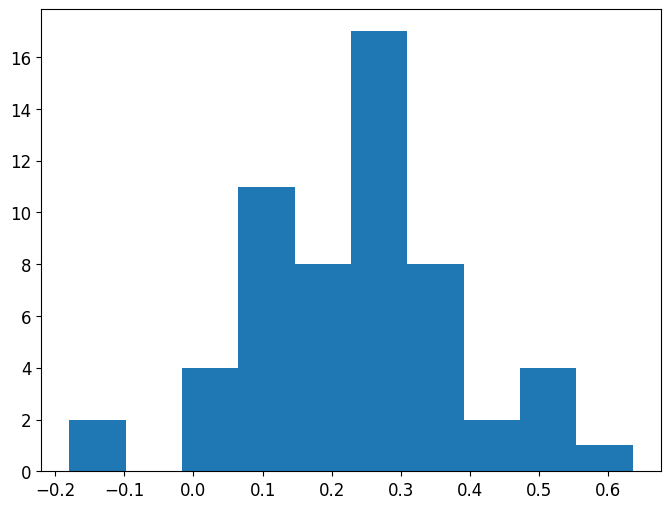

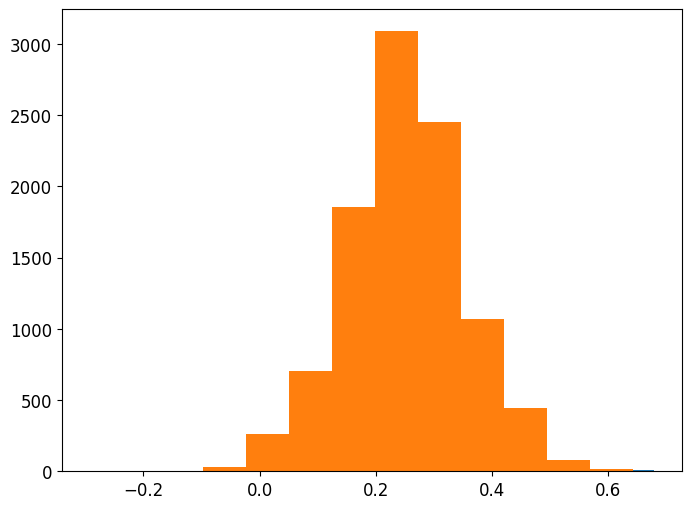

In [27]:
for LATDATA_each in constrained_fb:
    plt.figure()
    plt.hist(LATDATA_each) 
plt.figure()
totcld_tau_amt_g_t_mean = lat_weight_mean(totcld_tau_amt)[0]
plt.hist(totcld_tau_amt_g_t_mean)
# plt.figure()
plt.hist(global_mean)

In [28]:
# --- choose only the areas with positive correlation in ∆P-E in each run
